## Analysis with GeoPandas
In this exercise, we use GeoPandas to identify census tracts within 1km of EV charging locations in a region in NC. 
* [Input/Output](https://geopandas.org/io.html) Reading a CSV file into a GeoPandas geodataframe
* [Index and Selecting data](https://geopandas.org/indexing.html): Subsetting records
* [Managing Projections](https://geopandas.org/projections.html): Projecting a geodataframe
* [Geometric manipulations](https://geopandas.org/geometric_manipulations.html): Buffering points
* [Set operations](https://geopandas.org/set_operations.html): intersect
* [Aggregrating data](https://geopandas.org/aggregation_with_dissolve.html): Dissolving features

#### ♦Step 1. Import packages needed in the analysis
>**Knowledge check**:<br>
→ Can you explain what each package imported above does?

In [1]:
#Import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import contextily as ctx

%matplotlib inline

#### ♦Step 2. Create a geodataframe from a CSV file
As done in a previous notebook, we want to:
1. Import a CSV file containing coordinate columns into a Pandas dataframe,
1. Create a collection of Shapely points from the coordinate fields, and 
1. Create a geodataframe from the components. 

In [2]:
#Read in charging stations CSV, convert to geodataframe
df = pd.read_csv('./data/NC_Charging_Stations.csv')
geom = [Point(xy) for xy in zip(df['Longitude'],df['Latitude'])]
gdf_stations_all = gpd.GeoDataFrame(df,geometry=geom,crs=4326)

#### ♦Step 3. Explore the data in geodataframe
Have a quick look at the contents imported. Things to check include:
* How many rows and columns were imported
* The names, data types, and number of non-null values in each column
* Summary statistics of numeric columns, if applicable
* Correlations among column values, if applicable
* Spatial plot of the data

In [3]:
#Examine the data
gdf_stations_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   index                             738 non-null    int64   
 1   Fuel Type Code                    738 non-null    object  
 2   Station Name                      738 non-null    object  
 3   City                              738 non-null    object  
 4   State                             738 non-null    object  
 5   ZIP                               738 non-null    int64   
 6   Status Code                       738 non-null    object  
 7   Groups With Access Code           738 non-null    object  
 8   Latitude                          738 non-null    float64 
 9   Longitude                         738 non-null    float64 
 10  ID                                738 non-null    int64   
 11  Updated At                        738 non-null    

In [ ]:
#Plot the data
gdf_stations_all.plot();

---
### ►TASK: Import the USGS gage points for NC: `./data/gages.csv`
* Convert data to a geodataframe: `gdf_gages`
* Explore the data
* Plot the gage sites

---
### Importing NC Census Block Group features via NC OneMap's web service
We will explore web services a bit later, but we'll use the code below to acquire polygon data of census block groups for Durham, Wake, and Orange counties from an NC OneMap Web Service. Once imported, we'll merge these geodataframes together and use them in our subsequet analyses.

* First, to simplify matters, I've created a Python function to fetch data for a specific county given its FIPS code.

In [83]:
#Create a function to read NCOneMap feature services into a geodataframe
def getBlockGroupData(FIPS):
    #Construct the url from the function arguments
    url=f'https://services.nconemap.gov/secure/rest/services/NC1Map_Census/FeatureServer/8/query?' + \
        f"where=GEOID10+LIKE+'{FIPS}%'&outFields=GEOID10,TOTAL_POP&f=geojson"
    
    #Create a geodataframe from the URL
    gdf = gpd.read_file(url)
    
    #Return the geodataframe
    return gdf

* Now, we apply that function for the three counties we want to examine

In [84]:
#Fetch census block groups for Durham, Orange, and Wake counties using the above function
gdf_DurmBlkGroups = getBlockGroupData(37063)
gdf_WakeBlkGroups = getBlockGroupData(37183)
gdf_OrangeBlkGroups = getBlockGroupData(37135)

In [ ]:
#Challenge: See if you can fetch Chatham county block groups (FIPS = 37037)


* As before, let's take a moment to explore one of the geodataframes...
 * What is its coordinate reference system?
 * What columns are included?
 * What does the first record look like?

In [73]:
#Explore one of the dataframes
gdf_DurmBlkGroups.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [85]:
gdf_DurmBlkGroups.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GEOID10    153 non-null    object  
 1   TOTAL_POP  153 non-null    int64   
 2   geometry   153 non-null    geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 3.7+ KB


In [86]:
gdf_DurmBlkGroups.iloc[0]

GEOID10                                           370630020072
TOTAL_POP                                                 2306
geometry     POLYGON ((-78.93115770704857 35.95827210689065...
Name: 0, dtype: object

<AxesSubplot:>

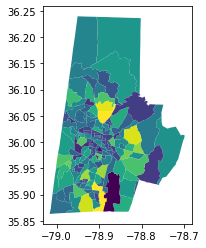

In [87]:
#Plot Durhham's population
gdf_DurmBlkGroups.plot('TOTAL_POP',cmap='viridis')

In [ ]:
#Plot the block groups
thePlot = gdf_DurmBlkGroups.plot(color='blue')
gdf_WakeBlkGroups.plot(ax=thePlot,color='red')
gdf_OrangeBlkGroups.plot(ax=thePlot,color='lightblue');

### The analysis
Now that we've obtained a few datasets and got them into geodataframes, we'll perform some analysis. These include:
* [**Step 1**](#Analysis-Step-1.-Attribute-subset-of-EV-Station-data) Subsetting the EV charging stations for those in specific cities.
* Identifying the census blocks surrounding each EV station, within a distance of 1km
 * To do this, we'll merge the Durham, Wake, and Orange Co block data selected above
 * Then we'll buffer our selected EV station points a distance of 1km
 * And finally, we'll select blocks that intersect the EV station buffers

#### Analysis Step 1. Attribute subset of EV Station data
1. Examine unique values in the `City` column

In [ ]:
svi_url

In [ ]:
#Reveal the unique values in the City column
gdf_stations_all['City'].unique()

2. Subset records for those where the City is "Durham", "Raleigh", or "Chapel Hill"

In [ ]:
#Subset records where the City is "Durham", "Raleigh", or "Chapel Hill"
gdf_stations = gdf_stations_all.query('City in ("Durham","Raleigh","Chapel Hill")')

3. Explore the results...

In [ ]:
#Plot the results
gdf_stations.plot("City");

In [ ]:
#Plot them with a base map
fig, ax = plt.subplots(figsize = (10,5))
gdf_stations.to_crs(3857).plot(ax=ax, column="City")
ctx.add_basemap(ax)

#### Analysis Step 2: Buffer the points
 * To do this, first we need to project the data to a crs that uses meters: UTM Zone 17N. To find the EPSG number associated with this crs, navigate to https://epsg.org and search for `UTM Zone 17 N`. In the results, find the entry associated with WGS84, and record its epsg number. (It should be 32617.)

In [ ]:
#Transform stations to UTM Zone 17N 
gdf_stations_utm = gdf_stations.to_crs(32617)
print(gdf_stations_utm.crs)

In [ ]:
#Buffer the selected exits 2.5 km
gdf_stations_buffer = gdf_stations_utm.buffer(1000)
gdf_stations_buffer.plot(alpha=0.2);

#### Analysis Step 3. Merge the 3 county block group geodataframes into one
Doc: https://geopandas.org/mergingdata.html
1. Check that all data have the same crs
1. Optionally, add a field to identify the source geodataframe
1. Apply the append() function

We'll start by appending the Wake Co. dataset to the Durham Co. one. Then you will append the Orange Co. dataframe to that product.

In [ ]:
#Check the crs of the two geodataframes
gdf_DurmBlkGroups.crs == gdf_WakeBlkGroups.crs

In [ ]:
#Add a field to each input, setting values to identify the source dataset
gdf_DurmBlkGroups['County'] = 'Durham'
gdf_WakeBlkGroups['County'] = 'Wake'

In [ ]:
#Append the Wake Co features to the Durham Co features,
gdf_BlkGrp_step1 = gdf_DurmBlkGroups.append(gdf_WakeBlkGroups)

>**Knowledge check**:<br>
→ How might we check to see that the size of the new geodataframe reflects the combination of the two input geodataframes?

In [ ]:
#Plot the result
gdf_BlkGrp_step1.plot('County');

* Now you try to append the Orange Co blockgroup features to the `gdf_BlkGrp_step` geodataframe we just created.<br>→ Remember to:
 * check that the coordinate refernce systems are the same, and 
 * add a new column to the `gdf_OrangeBlkGroups`, setting its value to the County name.
 
Save the result as `gdf_BlkGrps`

In [ ]:
#Check that the coordinate refernce systems are the same
gdf_BlkGrp_step1.crs == gdf_OrangeBlkGroups.crs

In [ ]:
#Add the county field
gdf_OrangeBlkGroups['County'] = 'Orange'

In [ ]:
#Append the geodataframes
gdf_BlkGrp = gdf_BlkGrp_step1.append(gdf_OrangeBlkGroups)

In [ ]:
gdf_BlkGrp.describe()

In [ ]:
#Plot the output
gdf_BlkGrp.plot('County');

#### Analysis Step 3: Compute Population Density
Our combined dataframes have a field indicating the total population in each block group. We want to compute population density from this and from the area of each block group. We don't yet have an area field in our dataframe, but we can compute that from our spatial features. But before we can do this, we need to transform our data into a projected coordinate system. So... the steps for this analysis include:
* Project the dataframe from WGS84 to UTM Zone 17N
* Compute a new `Area_km2` column in our dataframe
* Compute a new `PopDens` column in our dataframe by dividing `TOTAL_POP` by `Area_km` 

In [ ]:
#Project the data to UTM Zone 17N (EPSG 32617)
gdf_BlkGrp_utm = gdf_BlkGrp.to_crs(32617)

In [ ]:
#Compute a new column of geometry area (in sq km)
gdf_BlkGrp_utm['Area_km2'] = gdf_BlkGrp_utm['geometry'].area / 1000000

In [ ]:
#Compute a new column of population density
gdf_BlkGrp_utm['PopDens'] = gdf_BlkGrp_utm['TOTAL_POP'] / gdf_BlkGrp_utm['Area_km2']

In [ ]:
#Plot the distribution of areas
gdf_BlkGrp_utm['PopDens'].hist(bins=20);

In [ ]:
#Plot a map of log tranformed population density
gdf_BlkGrp_utm.plot('PopDens',figsize=(10,8),cmap='viridis');

In [ ]:
#Log transform the pop_dens data
import numpy as np
gdf_BlkGrp_utm['PD_log'] = np.log(gdf_BlkGrp_utm['PopDens'])

In [ ]:
#Plot the log-transformed distribution of areas
gdf_BlkGrp_utm['PD_log'].hist(bins=20);

In [ ]:
#Plot a map of log tranformed population density
gdf_BlkGrp_utm.plot('PD_log',figsize=(10,8),cmap='viridis');

In [ ]:
gdf_BlkGrp_utm.columns

#### Analsysis: Dissolve blocks into counties
Doc: https://geopandas.org/aggregation_with_dissolve.html
Here we examine the process of dissolving features. This is done easily with the `dissolve` function, which requires a field containing values on which we want to dissolve. 

We can also supply an `aggfunc()` argument which specifies how associated fields are aggregated. This argument is supplied as a single over all aggregate function (e.g. '`mean`') to be applied to all fields, or as a dictionary where the keys are the columns and the values are the individual aggregate functions applied to the respective field. 

Below we aggregate our block group dataset on the County field, computing the sum of values in the `TOTAL_POP` field and the mean of values in the `PopDens` field for each county. 

In [ ]:
#Dissolve Tracts on Counties
gdf_Counties = gdf_BlkGrp_utm.dissolve(by='County',aggfunc={'TOTAL_POP':'sum','PopDens':'mean'})
gdf_Counties.head()

In [ ]:
#Plot the results
gdf_Counties.plot();

#### Analysis: Subset EV stations spatially. 
Doc: https://geopandas.org/set_operations.html
Previously, we subset EV stations by an attribute (City). Here we'll see how we can instead select features spatially. We do this with GeoPanda's Overlay operations.

To spatially select features:
* Ensure both datasets share the same coordinate reference system; transform if needed
* 

In [ ]:
#plot points on tracts
ax = gdf_Counties.boundary.plot(figsize=(12,6))
gdf_stations_utm.plot(column='City',ax=ax,markersize=10);

* Get both datasets into the same crs

In [ ]:
#Ensure both datasets share the same crs
print(gdf_stations_all.crs, gdf_Counties.crs)

In [ ]:
#Project one dataset to match the other
gdf_stations_all_utm = gdf_stations_all.to_crs(gdf_Counties.crs)
print(gdf_stations_all_utm.crs)

* Select EV stations that intersect the county features.

In [ ]:
#Show info on the overlay function
gdf_stations_select = gpd.overlay?

In [ ]:
#Intersect the two dataframes
gdf_stations_select = gpd.overlay(
    df1=gdf_stations_all_utm,
    df2=gdf_Counties,
    how='intersection'
)

In [ ]:
gdf_stations_select.head()

In [ ]:
#Plot
ax = gdf_Counties.plot(color='lightgrey',edgecolor='black')
gdf_stations_select.plot(ax=ax,column='City',markersize=10);

#### Analysis: Spatial Join
Doc: https://geopandas.org/mergingdata.html#spatial-joins

Now that we have a proper susbset of EV stations, let's examine the block groups in which each EV stations falls. We do this with a Spatial Join 

In [ ]:
#Get syntax of sjoin function
gpd.sjoin?

In [ ]:
#Buffer the selected sites
gdf_stations_select['geometry'] = gdf_stations_select.buffer(1000)

In [ ]:
#Execute the spatial join
gdf_JoinedData = gpd.sjoin(
    left_df = gdf_stations_select,
    right_df = gdf_BlkGrp_utm,
    how='inner',
    op='intersects'
)

In [ ]:
gdf_JoinedData.plot()